In [2]:
import polars as pl
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
import numpy as np
import geopandas as gpd
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from sklearn.decomposition import PCA
import dill as pickle
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, SplineTransformer, KernelCenterer, PolynomialFeatures, PowerTransformer, QuantileTransformer, Normalizer
from itertools import chain
import math
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [3]:


def make_relative_ternary(df:pl.DataFrame, expectations=None):
    if expectations is None:
        #We can do this all as one statement with polars ofc but want to save training expectations so they can be applied to test data
        expectations = df.with_columns(pl.col('target').mean().over(['muni_id', 'month']).alias('expected')).group_by(['muni_id', 'month']).agg(pl.col('expected').first()).sort('month')

    return (
            (
                df
                .join(expectations, on=['muni_id', 'month'])
                .with_columns(
                    pl.when(pl.col('target')<=pl.col('expected')*.5)
                    .then(pl.lit('0'))
                    .when((pl.col('target')>pl.col('expected')*.5)&(pl.col('target')<=pl.col('expected')))
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('2'))
                    .alias('cat_target')
                    )
                .select(pl.exclude('expected'))
            ),
            expectations
    )


In [106]:

def make_relative_binary(df:pl.DataFrame, expectations=None):
    if expectations is None:
        #We can do this all as one statement with polars ofc but want to save training expectations so they can be applied to test data
        expectations = df.with_columns(pl.col('target').mean().over(['muni_id','month']).alias('expected')).group_by(['muni_id', 'month']).agg(pl.col('expected').first()).sort('month')

    return (
            (
                df
                .join(expectations, on=['muni_id', 'month'])
                .with_columns(
                    pl.when(pl.col('target')>pl.col('expected'))
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('0'))
                    .alias('cat_target')
                    )
                .select(pl.exclude('expected'))
            ),
            expectations
    )

In [4]:
monthly_cases = pl.read_parquet('../data/cases/agged/dengue_per_month.parquet').with_columns(pl.col('DT_NOTIFIC').dt.offset_by('1mo').alias('end_date')).with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
'DT_NOTIFIC': 'start_date',
'ID_MUNICIP': 'muni_id'
})

weekly_cases = pl.read_parquet('../data/cases/agged/dengue_per_week.parquet').with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
'DT_NOTIFIC': 'start_date',
'ID_MUNICIP': 'muni_id'
}).with_columns(pl.col('start_date').dt.month().alias('month'))

monthly_params = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')

ALL_DATA = monthly_cases.join(monthly_params, how='inner', on=['muni_id', 'end_date']).with_columns(pl.col('end_date').alias('month').dt.month())
TRAIN_START = '2005-01-01'
TRAIN_END = '2018-01-01'

TEST_START = '2018-01-01'
TEST_END = '2020-01-01'

EL = 12
LC = 24
binary_error = [np.array([-999.0, -999.0])]
ternary_error = [np.array([-999.0, -999.0, -999.0])]
SAVE_DIR = '/home/tony/dengue/dengue_models/results/'
SAVE_PREFIX = 'relative_binary_global'
CAT_STYLE = 'relative_binary_global'
CAT_FN = make_relative_ternary
ERROR_ARR = binary_error
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp').astype({'CD_MUN': 'string'})
munis['CD_MUN'] = munis['CD_MUN'].str.slice(stop=-1).astype(int)
ALL_DATA = ALL_DATA.join(pl.DataFrame(munis.drop(columns='geometry')), how='left', left_on='muni_id', right_on='CD_MUN').select(pl.exclude(['NM_MUN', 
                                                                                          'geometry'])).with_columns((pl.col('pop')/pl.col('AREA_KM2')).alias('density'))

In [47]:

def create_data_dict(start_date, 
                    end_date, 
                    all_data: pl.DataFrame, 
                    target_var = 'cases_per_100k',
                    case_lookback=24,
                    case_lag=1,
                    env_lag=0, 
                    env_lookback = 12,
                    env_list = [
                    # 'total_precipitation_sum', 
                    # 'temperature_2m', 
                    ],
                    additional_features = [
                        'month', 
                        'SIGLA'
                        # 'pop', 
                        # 'density', 
                        # 'x_centroid', 
                        # 'y_centroid'
                        ],
                    return_dict = False,
                    specific_cases = None,
                    specific_env = None
                    ):
    to_return = (
        all_data
        #.with_columns(pl.col('muni_id').alias('muni_cat'))
        .select(['muni_id', 'start_date', target_var] + env_list + additional_features)
        
        .with_columns(
            list(
                chain.from_iterable(
                    [
                        [pl.col(target_var).shift(i).over('muni_id').alias(f'{i}_shifted_cases')] for i in (range(case_lag,case_lookback+case_lag) if specific_cases is None else specific_cases)
                    ]
                    +
                    
                    [
                        [pl.col(e_var).shift(i).over('muni_id').alias(f'{i}_shifted_{e_var}') for i in (range(env_lag,env_lookback+env_lag) if specific_env is None else specific_env)] 
                            for e_var in env_list
                    ]
                    )
                )
        )
        .drop_nulls()
        .filter((pl.col('start_date')>=datetime.fromisoformat(start_date)) & (pl.col('start_date')<datetime.fromisoformat(end_date)))
        .select(pl.exclude(env_list))
        .rename({target_var: 'target'})
    )

    return to_return if not return_dict else to_return.partition_by('muni_id', as_dict=True)

In [6]:
def get_features_for_muni(df, cat_fn=None, check_zeros=False, cat_vars = None):
    df = df.sort('start_date')
    if check_zeros:
        if df.select(pl.col('target')).to_series().sum() == 0:
            return None
    selected = df if cat_fn is None else cat_fn(df)
    expectations = None
    #Some cat_fns return a tuple including expectations for category breaks based on historical data. If so, we want to pass these from training to testing data.
    if isinstance(selected, tuple):
        selected, expectations = selected
    target_key = 'target' if cat_fn is None else 'cat_target'
    target = selected.select(pl.col(target_key)).to_series().to_numpy().astype(float) 
    
    #TODO: Fix how months are handled
    features = selected.select(pl.exclude(['muni_id', 'start_date', 'target', 'count', 'cat_target'])).to_pandas()
    if cat_vars is not None:
        features[cat_vars] = features[cat_vars].astype('category')
    dates = selected.select(pl.col('start_date')).to_series()
    muni_id = selected.select(pl.col('muni_id').first()).item()

    return {'X': features,
            'y': target,
            'dates': dates,
            'muni_id': muni_id,
            'expectations': expectations}

In [6]:
def handle_zero_case(muni_id):
    return pl.DataFrame({
        'predictions': [-999.0],
        'ground_truth': [-999.0],
        'date': [datetime.fromisoformat('1900-01-01')],
        'muni_id': [muni_id],
        'cat_style': ['NA'],
        'error': ['Only zeros in training data'],
        'probabilities': ERROR_ARR
    }).cast({'date':pl.Date})

In [7]:

def write_results(df: pl.DataFrame, save_dir, save_prefix, muni_id):
    #muni_id = df.select('muni_id').head(n=1).item()
    df.write_csv(os.path.join(save_dir, f'{muni_id}_{save_prefix}.csv'))

In [8]:
def make_simple_binary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([300], labels=['0','1']).alias('cat_target'))

In [9]:

def make_simple_ternary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([100,300], labels=['0','1', '2']).alias('cat_target'))

In [7]:
from sklearn.compose import make_column_selector
def train_global(train, cat_style='', train_transform=None, target_transform=None, ct=None, cat_vars = []):

    reg = HistGradientBoostingClassifier(
    random_state=42,
    loss='log_loss',
    categorical_features = cat_vars,
    early_stopping=True,
    class_weight='balanced',
    l2_regularization=0.8,
    learning_rate=0.02,
    max_leaf_nodes=16,
    min_samples_leaf=50,
    max_iter=5000,
    scoring='balanced_accuracy'
    )

    if ct is None:
        ct = make_column_transformer(
            (OrdinalEncoder(), make_column_selector(dtype_include='category')),
            (RobustScaler(), make_column_selector(dtype_exclude='category')),
        
        remainder='passthrough',
        verbose_feature_names_out=False)

    model = make_pipeline(ct, reg).set_output(transform='pandas')

    #train_x = ct.fit_transform(train['X'])
    #print(train_x[:,-1])
    #if train_transform is not None:
    #    train_x = train_transform(train_x)
    #test_x = ct.transform(test['X'])

    #train_y = train['y']
    #if target_transform is not None:
    #    train_y = target_transform(train_y)

    #sample_weight = compute_sample_weight('balanced', train['y'])
    model.fit(train['X'], train['y']
            #sample_weight=sample_weight
            )
    
    return model

In [8]:
def test_global(model, test, cat_style):
    #test_x = transformer.transform(test['X'])

    z = model.predict(test['X'])
    p_hat = model.predict_proba(test['X'])
    return pl.DataFrame({
        'predictions': z,
        'ground_truth': test['y'],
        'date': test['dates'],
        'muni_id': [test['muni_id']]*len(z),
        'cat_style': [cat_style]*len(z),
        'error': ['NONE'] * len(z),
        'probabilities': p_hat
    })

In [9]:
def train_models(
        train_transform = None, 
        target_transform = None, 
        ct = None, 
        train_args = {
            'start_date': TRAIN_START,
            'end_date': TRAIN_END,
            'all_data': ALL_DATA,
            'env_list': [],
            'return_dict': False,
            'additional_features': []
        },
        test_args = {
            'start_date': TEST_START,
            'end_date': TEST_END,
            'all_data': ALL_DATA,
            'env_list': [],
            'return_dict': False,
            'additional_features': []
        },
        cat_vars = [
            'month',
            'SIGLA'
        ],
        cat_fn = make_relative_ternary
):

    train_args['additional_features'] = train_args['additional_features'] + cat_vars
    test_args['additional_features'] = test_args['additional_features'] + cat_vars
    global_data = create_data_dict(**train_args)
    global_data = (
        global_data
        .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
        #.filter(pl.col('muni_sum')!=0)
        #.select(pl.exclude('muni_sum'))
    )

    skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
    global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))

    test_data= create_data_dict(**test_args).filter(~pl.col('muni_id').is_in(skip_munis))

    train_data = get_features_for_muni(global_data, cat_fn, check_zeros=False, cat_vars = cat_vars)
    expectations = train_data['expectations']
    global_model = train_global(train_data,cat_style=CAT_STYLE, train_transform=train_transform, target_transform=target_transform, ct=ct, cat_vars = cat_vars)


    new_cat_fn = partial(cat_fn, expectations = expectations)
    test_data = get_features_for_muni(test_data, new_cat_fn, check_zeros=False, cat_vars = cat_vars)



    results = test_global(global_model, test_data, CAT_STYLE)

    return results

In [9]:
predictions = train_models()

In [10]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79     90657
         1.0       0.15      0.60      0.25      7933
         2.0       0.62      0.56      0.59     30242

    accuracy                           0.66    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.66      0.71    128832



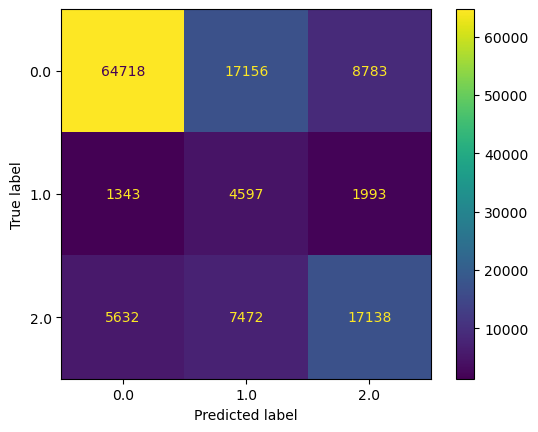

In [94]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 1: Random null training features
Results: Doesn't seem to have a large impact on accuracy. Having up to 85% of values missing doesn't even make much of an impact. There is a lot of noise

In [73]:
import numpy as np

def random_null(inp: np.array, p=0.25):
    rng = np.random.default_rng(12345)
    samples = rng.uniform(size=inp.shape)

    inp[samples<=p] = np.nan
    return inp


In [106]:
predictions = train_models(random_null)

26


In [75]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     90657
         1.0       0.16      0.57      0.25      7933
         2.0       0.61      0.57      0.59     30242

    accuracy                           0.67    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.67      0.71    128832



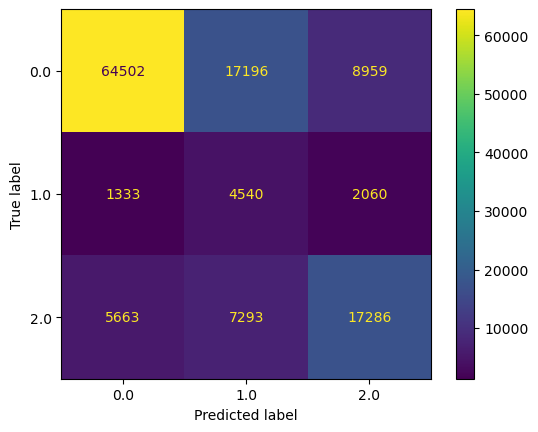

In [76]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 2: Additional random null training features
Results: Slows things down a lot, does not significantly improve results

In [99]:
import numpy as np

def random_null_add(inp: np.array, p=0.25):
    rng = np.random.default_rng(12345)
    samples = rng.uniform(size=inp.shape)
    copied = np.copy(inp)
    copied[samples<=p] = np.nan
    return np.concatenate((inp, copied))

def training_double(inp: np.array):
    return np.concatenate((inp, inp))


In [100]:
predictions = train_models(train_transform=random_null_add, target_transform=training_double)

In [101]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.75      0.81     90657
         1.0       0.16      0.46      0.24      7933
         2.0       0.59      0.60      0.60     30242

    accuracy                           0.70    128832
   macro avg       0.55      0.60      0.55    128832
weighted avg       0.78      0.70      0.73    128832



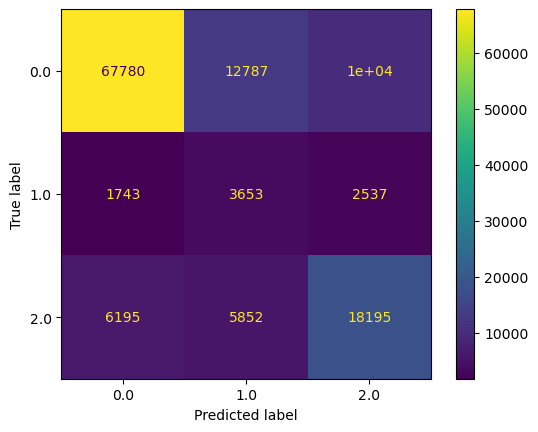

In [102]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 3: Adding PCA 
Results: Improves things? need to test more

In [101]:
pca_trans = ColumnTransformer([
            ('min_max', RobustScaler(), list(range(1, 26))),
            ('pca', PCA(n_components=10), list(range(1, 26)))
        ],
        remainder='passthrough')

In [102]:
predictions = train_models(ct=pca_trans)

27


/home/tony/mambaforge/envs/new_dengue/lib/python3.11/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1998: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


In [104]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     90657
         1.0       0.16      0.54      0.25      7933
         2.0       0.61      0.58      0.60     30242

    accuracy                           0.68    128832
   macro avg       0.56      0.62      0.55    128832
weighted avg       0.79      0.68      0.72    128832



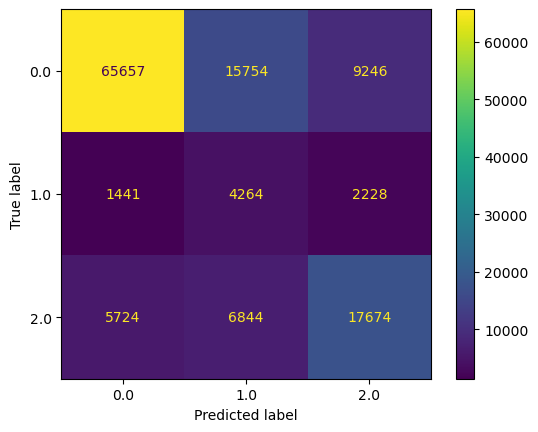

In [105]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

Test 3: Time Lag Search

In [58]:
global_data = create_data_dict(TRAIN_START, TRAIN_END, ALL_DATA, env_list=[
    'temporal_sdm_both',
    # 'temporal_sdm_albopictus',
    # 'temporal_sdm_aegypti',
    # 'EVI',
    # 'total_evaporation_sum',
    # 'total_precipitation_sum',
    # 'evaporation_from_open_water_surfaces_excluding_oceans_min',
    # 'soil_temperature_level_1',
    # 'runoff_sum',
    # 'surface_runoff_min',
    # 'volumetric_soil_water_layer_1',
    # 'dewpoint_temperature_2m',
    # 'temperature_2m',
    # 'total_precipitation_min'
], specific_cases= [1,12, 24],
additional_features= [
                'month',
                'density',
                'pop',
                'SIGLA'
            ],
            return_dict=False)
global_data = (
    global_data
    .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
    #.filter(pl.col('muni_sum')!=0)
    #.select(pl.exclude('muni_sum'))
)

skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))
train_data = get_features_for_muni(global_data, CAT_FN, check_zeros=False, cat_vars = ['month', 'SIGLA'])

In [59]:
train_data['X']

,month,density,pop,SIGLA,1_shifted_cases,12_shifted_cases,24_shifted_cases,0_shifted_temporal_sdm_both,1_shifted_temporal_sdm_both,2_shifted_temporal_sdm_both,3_shifted_temporal_sdm_both,4_shifted_temporal_sdm_both,5_shifted_temporal_sdm_both,6_shifted_temporal_sdm_both,7_shifted_temporal_sdm_both,8_shifted_temporal_sdm_both,9_shifted_temporal_sdm_both,10_shifted_temporal_sdm_both,11_shifted_temporal_sdm_both
0,2,58.909587,57783,PE,34.618847,17.309423,1.731572,0.274923,0.424357,0.524242,0.811656,0.707249,0.608326,0.600787,0.747969,0.570478,0.561508,0.571820,0.710814
1,2,6858.834872,1501008,PE,8.474183,3.900814,10.401555,0.096570,0.664807,0.664807,0.174573,0.393609,0.485142,0.423136,0.197599,0.341072,0.335261,0.335261,0.664807
2,2,594.334336,232251,RJ,3.516994,7.033987,7.311912,0.516870,0.711086,0.797725,0.746080,0.706990,0.736959,0.693028,0.693428,0.728113,0.655622,0.468956,0.491624
3,2,109.948449,257535,MG,5.867374,111.088945,24.975520,0.042569,0.400147,0.401969,0.474220,0.706696,0.714901,0.711265,0.766703,0.744127,0.507906,0.247651,0.189705
4,2,32.018151,41376,TO,12.545163,65.234845,2.583312,0.131488,0.095962,0.130384,0.384195,0.036719,0.105184,0.141238,0.092267,0.099201,0.122354,0.238828,0.342839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837403,1,25.562015,77514,CE,0.000000,2.588628,1.298735,0.108133,0.088385,0.077908,0.108008,0.145047,0.341072,0.341072,0.341072,0.147098,0.106248,0.117337,0.103960
837404,1,247.219925,32280,PE,3.097893,0.000000,907.559880,0.664807,0.095962,0.265683,0.543138,0.572977,0.475147,0.230187,0.111233,0.664807,0.664807,0.664807,0.664807
837405,1,19.431012,7024,PB,0.000000,0.000000,0.000000,0.026259,0.027844,0.097366,0.141238,0.265683,0.293792,0.190201,0.207813,0.088477,0.095334,0.046891,0.026081
837406,1,12.655576,5134,MG,0.000000,0.000000,0.000000,0.676154,0.705032,0.675922,0.598359,0.723319,0.732159,0.582897,0.582078,0.674792,0.707249,0.734556,0.783926


In [66]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
X, y = train_data['X'], train_data['y']
ct = make_column_transformer(
            (OrdinalEncoder(), make_column_selector(dtype_include='category')),
            (Normalizer(), make_column_selector(dtype_exclude='category')),
        
        remainder='passthrough')
ct.fit_transform(X)[:,18]


array([1.23014259e-05, 4.42902702e-07, 2.11677073e-06, ...,
       3.71316942e-06, 1.52692525e-04, 1.64877864e-05])

Months since last peak feature??? Or is this captured by historic

Position within relative dengue season

Change rates instead of hi/low/medium classfication
changing rapidly up, down, medium

fit some kind of periodic function per municipio based on standardized case rates -> model that takes periodic function fit to standardized data so that all municipios you can reapply results to own actual period function - look at peaks

In [117]:
from sklearn.feature_selection import SequentialFeatureSelector

hist_model = HistGradientBoostingClassifier(random_state=42,
    #categorical_features = [n_components-1],
    #l2_regularization=.05,
    #categorical_features=[15],
    max_iter=500, 
    #learning_rate=0.5,
    #max_leaf_nodes=None, 
    #min_samples_leaf=10,
    #max_bins=255,
    early_stopping=True,
    class_weight='balanced',
    validation_fraction=0.3,
    n_iter_no_change=100)
#X = MinMaxScaler().fit_transform(X)
sfs = SequentialFeatureSelector(hist_model, n_features_to_select='auto', tol=0.001, scoring='f1_macro', cv=3, n_jobs=-1)
sfs.fit(X, y)

SequentialFeatureSelector(cv=3,
                          estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                   early_stopping=True,
                                                                   max_iter=500,
                                                                   n_iter_no_change=100,
                                                                   random_state=42,
                                                                   validation_fraction=0.3),
                          n_features_to_select='auto', n_jobs=-1,
                          scoring='f1_macro', tol=0.001)

In [118]:
sfs.get_feature_names_out(
)

array(['1_shifted_cases', '13_shifted_cases', '24_shifted_cases',
       '8_shifted_surface_runoff_min'], dtype=object)

Test 4: non-contiguous time period
Results: Inconclusive


              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80     80361
         1.0       0.37      0.61      0.46     18474
         2.0       0.56      0.62      0.59     24629

    accuracy                           0.69    123464
   macro avg       0.61      0.65      0.61    123464
weighted avg       0.74      0.69      0.71    123464



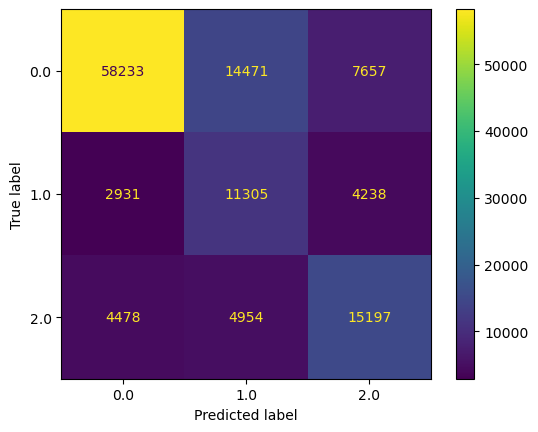

In [146]:
predictions = train_models(train_args = {
            'start_date': TRAIN_START,
            'end_date': TRAIN_END,
            'all_data': ALL_DATA,
            'env_list': [
                'temporal_sdm_aegypti',
                'temporal_sdm_albopictus',
                #'soil_temperature_level_1'
                #'temporal_sdm_both'
                ],
            'return_dict': False,
            'specific_cases': [1,2,3,12,13, 24,25],
            'specific_env': [0,1,2, 11, 23],
            'additional_features': [
                'density',
                #'pop'
            ]
        },
        test_args = {
            'start_date': TEST_START,
            'end_date': TEST_END,
            'all_data': ALL_DATA,
            'env_list': [
                'temporal_sdm_aegypti',
                'temporal_sdm_albopictus',
                #'soil_temperature_level_1'
                #'temporal_sdm_both'
                ],
            'return_dict': False,
            'specific_cases': [1,2,3,12,13, 24,25],
            'specific_env': [0,1,2, 11, 23],
            'additional_features': [
                'density',
                #'pop'
            ]
        },
        cat_vars = [
            'month', 
            'SIGLA'
            ],
        cat_fn=make_relative_ternary
)
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

In [145]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80     80361
         1.0       0.37      0.61      0.46     18474
         2.0       0.56      0.62      0.59     24629

    accuracy                           0.69    123464
   macro avg       0.61      0.65      0.61    123464
weighted avg       0.74      0.69      0.71    123464



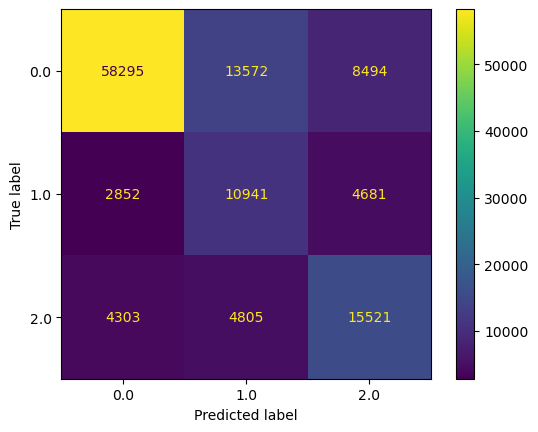

In [142]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

5: Setting up timeseries kfold validation for tests:

In [7]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate

splitter = TimeSeriesSplit()
global_data = create_data_dict('2001-01-01', '2020-11-01', ALL_DATA, env_list=[
], specific_cases= [1,12, 24],
additional_features= [
                'month',
                'density',
                'pop'
            ],
            return_dict=False)
global_data = (
    global_data
    .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
)

skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))
train_data = get_features_for_muni(global_data, make_relative_ternary, check_zeros=False)


In [48]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

cat_columns = ['month']

scaler = make_column_transformer(
    (RobustScaler(), make_column_selector(dtype_exclude='uint32')), remainder="passthrough", verbose_feature_names_out=False,
)


hist_model = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    class_weight='balanced',
    categorical_features=cat_columns,
    l2_regularization=0.8,
    learning_rate=0.02,
    max_leaf_nodes=16,
    min_samples_leaf=50,
    max_iter=4000
    )
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=50,
    criterion='entropy'
)
hist_pipeline = make_pipeline(scaler, hist_model).set_output(transform='pandas')
rf_pipeline = make_pipeline(scaler, rf_model).set_output(transform='pandas')
vote_pipeline = make_pipeline(scaler, VotingClassifier([('hist', hist_model), ('rf', rf_model)])).set_output(transform='pandas')
#voter = VotingClassifier([hist_pipeline, rf_pipeline])

cross_validate(hist_pipeline, train_data['X'], train_data['y'], scoring=['f1_macro', 'f1_weighted', 'balanced_accuracy'], cv=TimeSeriesSplit(), n_jobs=-1)


{'fit_time': array([ 15.50523829,  43.7184689 ,  96.18016195, 132.16300011,
        202.23592615]),
 'score_time': array([ 8.52636933, 12.9847343 , 16.86812782, 17.50940824, 21.44417691]),
 'test_f1_macro': array([0.48046069, 0.5139142 , 0.52390569, 0.53248819, 0.54602781]),
 'test_f1_weighted': array([0.7146158 , 0.69987148, 0.67997332, 0.68817676, 0.71265366]),
 'test_balanced_accuracy': array([0.5554468 , 0.58649792, 0.59785814, 0.61006448, 0.61592058])}

TODO: Halvinggridsearch - .02 learning rate best on first try
      Fix categorical variables and try state/cluster membership
      Features seaaaarch better

In [45]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import scipy.stats as stats

param_grid = {
    #'histgradientboostingclassifier__learning_rate': stats.loguniform(.0001, .1 ),
    #'histgradientboostingclassifier__l2_regularization': stats.uniform(0,2),
    #'histgradientboostingclassifier__max_leaf_nodes': stats.randint(1, 100),
    'histgradientboostingclassifier__min_samples_leaf': stats.randint(50, 250)
}

clf = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    class_weight='balanced',
    categorical_features=cat_columns,
    l2_regularization=0.8,
    learning_rate=0.02,
    max_leaf_nodes=16,
    min_samples_leaf=50
    )

grid_pipeline = make_pipeline(scaler, clf).set_output(transform='pandas')


gsh = HalvingRandomSearchCV(
    estimator=grid_pipeline, param_distributions=param_grid, factor=2, random_state=42, cv=TimeSeriesSplit(n_splits=4), scoring='balanced_accuracy', verbose=1,
    min_resources=100, max_resources=5000, resource='histgradientboostingclassifier__max_iter',
)

search = gsh.fit(train_data['X'], train_data['y'])
#grid_pipeline.named_steps


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 100
max_resources_: 5000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 100
Fitting 4 folds for each of 50 candidates, totalling 200 fits
----------
iter: 1
n_candidates: 25
n_resources: 200
Fitting 4 folds for each of 25 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 13
n_resources: 400
Fitting 4 folds for each of 13 candidates, totalling 52 fits
----------
iter: 3
n_candidates: 7
n_resources: 800
Fitting 4 folds for each of 7 candidates, totalling 28 fits
----------
iter: 4
n_candidates: 4
n_resources: 1600
Fitting 4 folds for each of 4 candidates, totalling 16 fits
----------
iter: 5
n_candidates: 2
n_resources: 3200
Fitting 4 folds for each of 2 candidates, totalling 8 fits


In [43]:
search.best_params_

{'histgradientboostingclassifier__l2_regularization': 0.7976488848891061,
 'histgradientboostingclassifier__learning_rate': 0.02813815513117022,
 'histgradientboostingclassifier__max_leaf_nodes': 16,
 'histgradientboostingclassifier__min_samples_leaf': 97,
 'histgradientboostingclassifier__max_iter': 3200}

In [47]:
search.best_params_


{'histgradientboostingclassifier__min_samples_leaf': 51,
 'histgradientboostingclassifier__max_iter': 3200}

Weekly Cases? This is dumb?
Two options: Concat weekly data to bottom of monthly data as additional training data -- This doesn't work
OR: Better option? Weekly case rates as additional features

In [29]:
weekly  = create_data_dict('2005-01-01', '2018-01-01', weekly_cases, additional_features=['month'], return_dict=False)
monthly = create_data_dict('2005-01-01', '2018-01-01', ALL_DATA, additional_features=['month'], return_dict=False)

monthly = (
    monthly
    .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
)

skip_munis = monthly.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
monthly = monthly.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))
weekly = weekly.filter(~pl.col('muni_id').is_in(skip_munis))


monthly_features = get_features_for_muni(monthly, make_relative_ternary, check_zeros=False)
weekly_features = get_features_for_muni(weekly, make_relative_ternary, check_zeros=False)

In [30]:
import pandas as pd
mt = make_column_transformer(
            (Normalizer(), make_column_selector(dtype_exclude='uint32')),
        remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

wt = make_column_transformer(
            (Normalizer(), make_column_selector(dtype_exclude='uint32')),
        remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')


combined_X = pd.concat([mt.fit_transform(monthly_features['X']), wt.fit_transform(weekly_features['X'])])
combined_y = np.concatenate([monthly_features['y'], weekly_features['y']])

test = create_data_dict('2018-01-01', '2020-01-01' , ALL_DATA, additional_features=['month'], return_dict=False)
test = test.filter(~pl.col('muni_id').is_in(skip_munis))

test_features = get_features_for_muni(test, partial(make_relative_ternary, expectations = monthly_features['expectations']), check_zeros=False)


In [28]:
np.unique(test_features['y'], return_counts=True)

(array([0., 1., 2.]), array([90657,  7933, 30242]))

In [31]:
clf = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    class_weight='balanced',
    categorical_features=['month'],
    l2_regularization=0.8,
    learning_rate=0.02,
    max_leaf_nodes=16,
    min_samples_leaf=50,
    max_iter=5000
    )

clf = clf.fit(combined_X, combined_y)

              precision    recall  f1-score   support

         0.0       0.93      0.55      0.69     90657
         1.0       0.13      0.67      0.21      7933
         2.0       0.51      0.55      0.53     30242

    accuracy                           0.56    128832
   macro avg       0.52      0.59      0.48    128832
weighted avg       0.78      0.56      0.63    128832



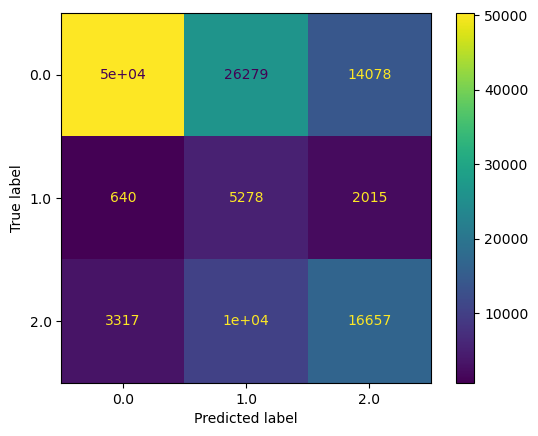

In [32]:
predictions = clf.predict(mt.transform(test_features['X']))
print(classification_report(test_features['y'],predictions))
ConfusionMatrixDisplay.from_predictions(test_features['y'],predictions)

#Weekly cases as additional features

temporal_sdm_both
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     90657
         1.0       0.15      0.57      0.24      7933
         2.0       0.61      0.57      0.59     30242

    accuracy                           0.67    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.67      0.71    128832

temporal_sdm_albopictus
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     90657
         1.0       0.16      0.57      0.24      7933
         2.0       0.61      0.56      0.59     30242

    accuracy                           0.67    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.67      0.71    128832



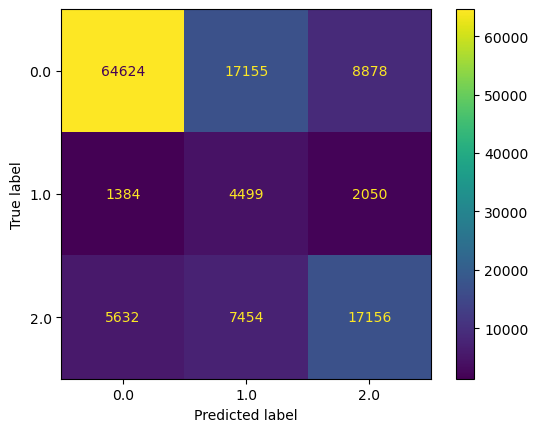

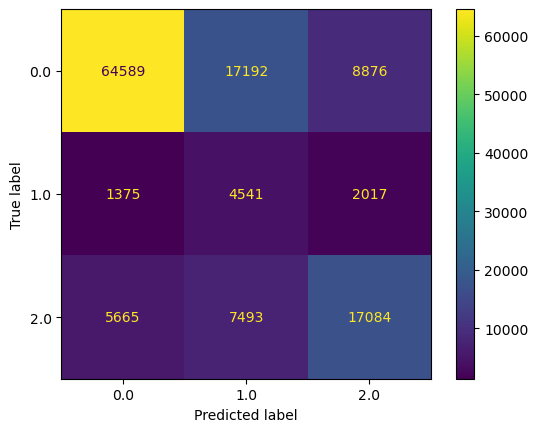

In [106]:
env_feats = [
'temporal_sdm_both',
 'temporal_sdm_albopictus',
 'temporal_sdm_aegypti',
 'EVI',
 'total_evaporation_sum',
 'total_precipitation_sum',
 'evaporation_from_open_water_surfaces_excluding_oceans_min',
 'soil_temperature_level_1',
 'runoff_sum',
 'surface_runoff_min',
 'volumetric_soil_water_layer_1',
 'dewpoint_temperature_2m',
 'temperature_2m',
 'total_precipitation_min',
]
results = []
for e_v in env_feats:
    num_weeks = 0
    time_lookback = 24
    #spec_cases = [11]
    adtl_feat = [
        'density', 
        #'pop'
    ]
    cat_feat = [
        'month', 
    #'SIGLA'
    ]
    weak_feat = [f'week_{i}' for i in range(0, num_weeks)]
    env_feat = [
        e_v
    ]
    specific_env = [0,1]

    mod_month = ALL_DATA.with_columns((
        pl.col('start_date').dt.offset_by('-1mo').dt.month().alias('join_month'),
        pl.col('start_date').dt.offset_by('-1mo').dt.year().alias('join_year')
    )
    )
    if num_weeks > 0:
        mod_weekly = (weekly_cases.with_columns(pl.col('start_date').dt.offset_by('1w').alias('end_date'))
                    .with_columns((
                        pl.col('end_date').dt.month().alias('join_month'),
                        pl.col('end_date').dt.year().alias('join_year')
                    )
        )
            .group_by(['muni_id', 'join_year', 'join_month'])
            .agg(pl.col('cases_per_100k').tail(num_weeks))
            .filter(pl.col('cases_per_100k').list.len() == num_weeks)
            .with_columns(pl.col('cases_per_100k').list.to_struct())
            .unnest('cases_per_100k')
        )

    month_week_df = mod_month.join(mod_weekly, on=['muni_id', 'join_year', 'join_month'], how='inner').rename({
        f'field_{i}': f'week_{i}' for i in range(0, num_weeks)}) if num_weeks>0 else ALL_DATA

    month_week_df.columns
    month_week_train = create_data_dict(TRAIN_START, 
                                        TRAIN_END, 
                                        month_week_df, 
                                        #env_list=['temporal_sdm_both'], 
                                        #env_lookback=24, 
                                        case_lookback=time_lookback, 
                                        env_list=env_feat,
                                        specific_env=specific_env,
                                        #specific_cases=spec_cases,
                                        additional_features=adtl_feat + cat_feat + weak_feat
                                        # + 
                                        #[f'week_{i}' for i in range(0, num_weeks)]
                                        )
    month_week_test = create_data_dict(TEST_START, 
                                        TEST_END, 
                                        month_week_df, 
                                        case_lookback=time_lookback,
                                        env_list=env_feat,
                                        specific_env=specific_env,
                                        #specific_cases=spec_cases,
                                        #env_list=['temporal_sdm_both'], 
                                        #env_lookback=24, 
                                        additional_features=adtl_feat + cat_feat + weak_feat
                                        )
    month_week_train = (
        month_week_train
        .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
    )

    skip_munis = month_week_train.filter(
        pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
    month_week_train = month_week_train.filter(
        pl.col('muni_sum') != 0).select(pl.exclude('muni_sum'))

    month_week_test = month_week_test.filter(~pl.col('muni_id').is_in(skip_munis))

    all_features_train = get_features_for_muni(
        month_week_train, make_relative_ternary, check_zeros=False, cat_vars=cat_feat)
    all_features_test = get_features_for_muni(month_week_test, partial(
        make_relative_ternary, expectations=all_features_train['expectations']), check_zeros=False, cat_vars=cat_feat)

    ct = make_column_transformer(
                (OrdinalEncoder(), make_column_selector(dtype_include='category')),
                (RobustScaler(), make_column_selector(dtype_exclude='category')),
                #(PCA(n_components=16), make_column_selector(dtype_exclude='category')),
            remainder='passthrough', 
            verbose_feature_names_out=False)

    clf = HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True,
        #scoring='balanced_accuracy',
        class_weight='balanced',
        categorical_features=cat_feat,
        # l2_regularization=0.8,
        # learning_rate=0.02,
        # max_leaf_nodes=16,
        # min_samples_leaf=50,
        max_iter=5000
        )

    month_week_pipeline = make_pipeline(ct, clf).set_output(transform='pandas')
    month_week_pipeline.fit(all_features_train['X'], all_features_train['y'])
    predictions = month_week_pipeline.predict(all_features_test['X'])
    results.append(classification_report(all_features_test['y'],predictions))
    print(e_v)
    print(classification_report(all_features_test['y'],predictions))
    ConfusionMatrixDisplay.from_predictions(all_features_test['y'],predictions)

In [107]:

month_week_train

muni_id,start_date,target,density,month,1_shifted_cases,2_shifted_cases,3_shifted_cases,4_shifted_cases,5_shifted_cases,6_shifted_cases,7_shifted_cases,8_shifted_cases,9_shifted_cases,10_shifted_cases,11_shifted_cases,12_shifted_cases,13_shifted_cases,14_shifted_cases,15_shifted_cases,16_shifted_cases,17_shifted_cases,18_shifted_cases,19_shifted_cases,20_shifted_cases,21_shifted_cases,22_shifted_cases,23_shifted_cases,24_shifted_cases,0_shifted_temporal_sdm_albopictus
i64,date,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
261090,2005-01-01,8.653064,58.909587,2,34.618847,3.461885,1.730942,3.461885,8.654712,8.654712,3.461885,6.923769,13.847539,32.887904,39.811673,17.309423,25.973576,0.0,10.38943,15.584146,67.531298,121.210022,199.130751,618.171114,841.543869,410.382504,96.968018,1.731572,0.156078
261160,2005-01-01,6.595568,6858.834872,2,8.474183,7.263585,6.725542,7.532607,11.836954,8.272417,5.851222,4.169836,5.514944,7.465352,7.801629,3.900814,4.105877,2.942545,3.626858,4.037446,4.721758,7.664304,7.595872,14.439,39.00583,23.061342,13.686256,10.401555,0.017817
330250,2005-01-01,2.583412,594.334336,2,3.516994,5.715115,1.758497,0.879248,0.0,0.0,0.439624,0.439624,2.198121,3.077369,3.077369,7.033987,9.596885,4.569945,5.483934,0.913989,0.0,2.741967,3.198962,8.682896,16.451803,14.623825,23.306721,7.311912,0.574829
312770,2005-01-01,8.542528,109.948449,2,5.867374,6.258532,3.520424,1.173475,0.391158,2.738108,7.040849,21.513704,183.062065,592.99592,268.725724,111.088945,29.732762,9.514484,5.550116,2.775058,1.18931,2.378621,11.100231,14.668163,24.579083,32.111383,37.661498,24.97552,0.024992
171610,2005-01-01,14.50116,32.018151,2,12.545163,27.599358,5.018065,0.0,5.018065,5.018065,25.090325,17.563228,30.10839,35.126455,97.852268,65.234845,80.082666,41.332989,18.083183,7.749935,7.749935,7.749935,25.833118,59.416172,72.332731,116.249031,33.583053,2.583312,0.064147
170210,2005-01-01,254.859984,31.843264,2,108.631326,89.174969,47.830211,20.267038,28.373854,38.102032,51.072937,99.713829,147.54404,130.519728,118.359505,102.956556,66.548543,48.247694,37.433555,7.486711,21.628276,29.114988,29.946844,84.017536,75.698968,109.805096,161.380217,127.274088,0.042159
354890,2005-01-01,4.655797,188.921345,2,0.948582,1.897164,2.845746,2.371455,0.948582,0.474291,0.474291,2.371455,2.845746,4.268619,7.114366,5.217202,2.454458,1.963566,3.436241,0.981783,2.945349,3.927132,3.436241,4.908915,9.81783,9.326939,15.708528,9.326939,0.936672
350320,2005-01-01,1.522541,196.327313,2,3.600805,1.028801,1.543202,0.0,3.086404,3.600805,0.514401,1.028801,2.057603,4.629606,4.115205,2.572003,2.109326,1.581995,1.581995,1.581995,1.054663,0.0,1.054663,4.745984,4.745984,8.964637,8.964637,4.745984,0.870379
350280,2005-01-01,8.902886,153.982518,2,7.872997,6.185926,5.061213,3.936499,5.061213,5.061213,7.872997,11.809496,24.743706,19.120136,15.183638,16.870709,12.614751,9.747762,6.307376,4.587182,18.922127,32.683674,67.660938,230.505909,285.552096,969.042254,489.681707,120.986932,0.114143


In [73]:
ALL_DATA.select('muni_id')

muni_id
i64
261090
261160
221140
330250
312770
313580
171610
170210
170755


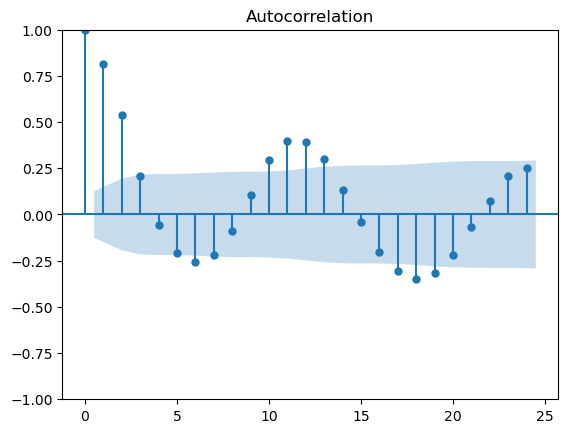

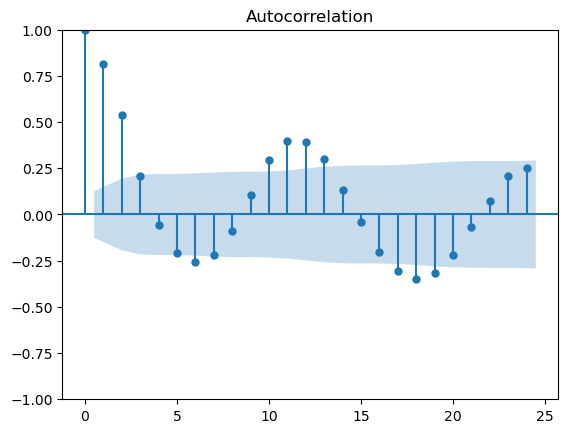

In [86]:
from statsmodels.graphics.tsaplots import plot_acf

to_plot = ALL_DATA.filter(pl.col('muni_id')==170210).select('cases_per_100k')

plot_acf(to_plot)

In [105]:
monthly_params.columns

['muni_id',
 'temporal_sdm_both',
 'start_date',
 'end_date',
 'temporal_sdm_albopictus',
 'start_date_temporal_sdm_albopictus',
 'temporal_sdm_aegypti',
 'start_date_temporal_sdm_aegypti',
 'EVI',
 'start_date_EVI',
 'total_evaporation_sum',
 'start_date_total_evaporation_sum',
 'total_precipitation_sum',
 'start_date_total_precipitation_sum',
 'evaporation_from_open_water_surfaces_excluding_oceans_min',
 'start_date_evaporation_from_open_water_surfaces_excluding_oceans_min',
 'soil_temperature_level_1',
 'start_date_soil_temperature_level_1',
 'runoff_sum',
 'start_date_runoff_sum',
 'surface_runoff_min',
 'start_date_surface_runoff_min',
 'volumetric_soil_water_layer_1',
 'start_date_volumetric_soil_water_layer_1',
 'dewpoint_temperature_2m',
 'start_date_dewpoint_temperature_2m',
 'temperature_2m',
 'start_date_temperature_2m',
 'total_precipitation_min',
 'start_date_total_precipitation_min']